In [1]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *

Loading imports


In [2]:
torch.cuda.set_device(4)

In [3]:
dbunch = get_3d_dbunch(Meta.df_any, bs=10)

In [4]:
x,y = dbunch.one_batch()
x.shape, y.shape

(torch.Size([10, 60, 3, 256, 256]), torch.Size([10, 60, 6]))

In [5]:
x

tensor([[[[[-0.6044, -0.6044, -0.6044,  ..., -0.6044, -0.6044, -0.6044],
           [-0.6044, -0.6044, -0.6044,  ..., -0.6044, -0.6044, -0.6044],
           [-0.6044, -0.6044, -0.6044,  ..., -0.6044, -0.6044, -0.6044],
           ...,
           [-0.6044, -0.6044, -0.6044,  ..., -0.6044, -0.6044, -0.6044],
           [-0.6044, -0.6044, -0.6044,  ..., -0.6044, -0.6044, -0.6044],
           [-0.6044, -0.6044, -0.6044,  ..., -0.6044, -0.6044, -0.6044]],

          [[-0.7976, -0.7976, -0.7976,  ..., -0.7976, -0.7976, -0.7976],
           [-0.7976, -0.7976, -0.7976,  ..., -0.7976, -0.7976, -0.7976],
           [-0.7976, -0.7976, -0.7976,  ..., -0.7976, -0.7976, -0.7976],
           ...,
           [-0.7976, -0.7976, -0.7976,  ..., -0.7976, -0.7976, -0.7976],
           [-0.7976, -0.7976, -0.7976,  ..., -0.7976, -0.7976, -0.7976],
           [-0.7976, -0.7976, -0.7976,  ..., -0.7976, -0.7976, -0.7976]],

          [[-2.7896, -2.7896, -2.7896,  ..., -2.7896, -2.7896, -2.7896],
           [-2.

## Model

In [6]:
m = get_3d_head()

In [7]:
config=dict(custom_head=m)
learn = get_learner(dbunch, xresnet34, get_loss(), config=config)

In [8]:
hook = ReshapeBodyHook(learn.model[0])
learn.add_cb(DePadLoss())

In [9]:
learn.load(f'runs/baseline_full256-2', strict=False)

In [10]:
learn.model

Sequential(
  (0): Sequential(
    (0): ConvLayer(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ConvLayer(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): ConvLayer(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): ResBlock(
        (convs): Sequential(
          (0): ConvLayer(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): Batch

In [11]:
# learn.summary()

## Training

In [12]:
name = 'train3d_baseline'

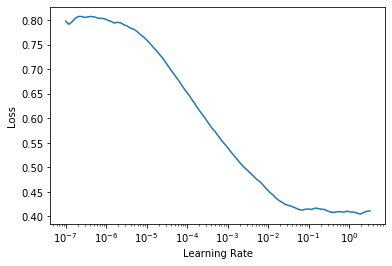

In [15]:
learn.lr_find()

In [ ]:
do_fit(learn, 6, 1e-2, freeze=True)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.115369,0.163566,0.945614,0.902768,10:28


epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.175922,0.244198,0.916505,0.845742,13:06
1,0.159906,0.174402,0.939553,0.899033,12:58
2,0.153641,0.155064,0.944877,0.903695,12:59
3,0.135699,0.155669,0.944356,0.905311,12:58
